## Дз №8. GAN

Обучите нейронную сеть любой архитектуры на каком-то производственном датасете. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.

В конце, обязательно подвести вывод.

Данная промежуточная аттестация оценивается по системе "зачет" / "не зачет" Зачет" ставится, если слушатель успешно выполнил задание 1 или 2 задания "Незачет"" ставится, если слушатель не выплнил 0 заданий

Генеративно-состязательная нейросеть (англ. Generative adversarial network, сокращённо GAN) – это модель машинного обучения, умеющая имитировать заданное распределение данных. Впервые модель была предложена в статье NeurIPS 2014 г. экспертом в глубоком обучении Яном Гудфеллоу и его коллегами.

GAN состоят из двух нейронных сетей, одна из которых обучена генерировать данные, а другая – отличать смоделированные данные от реальных (отсюда и «состязательный» характер модели). Генеративно-состязательные нейросети показывают впечатляющие результаты в отношении генерации изображений и видео:




## Архитектура генеративно-состязательных нейросетей

Генеративно-состязательная сеть, как мы уже поняли, – это не одна сеть, а две: генератор и дискриминатор. Роль генератора – сгенерировать на основе реальной выборки датасет, напоминающий реальные данные. Дискриминатор обучен оценивать вероятность того, что образец получен из реальных данных, а не предоставлен генератором. Две нейросети играют в кошки-мышки: генератор пытается обмануть дискриминатор, а дискриминатор старается лучше идентифицировать сгенерированные образцы.

In [25]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

Импортируем библиотеку PyTorch (torch). Из библиотеки отдельно импортируем компонент nn для более компактного обращения. Встроенная библиотека math нужна для получения значения константы pi, а упомянутый выше инструмент matplotlib – для построения зависимостей.

Генератор случайных чисел нужен, чтобы эксперимент можно было воспроизвести на другой машине. Чтобы сделать это в PyTorch, запустим следующий код:

In [26]:
torch.manual_seed(42)

## Подготовка данных для обучения

Обучающая выборка состоит из пар чисел  – таких, что  соответствует значению синуса  для  в интервале от до . Данные для обучения можно получить следующим образом:

In [27]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)]

Здесь мы составляем набор данных для обучения, состоящий из 1024 пар (x1;x2). Затем инициализируем нулями train_data – матрицу из 1024 строк и 2 столбцов.

Первый столбец train_data заполняем случайными значениями в интервале от 0 до 2Пи. Вычисляем значения второго столбца, как синус от первого.

Затем нам формально потребуется массив меток train_labels, который мы передаем загрузчику данных PyTorch. Поскольку GAN реализует метод обучения без учителя, метки могут быть любыми.

Наконец, мы создаем из train_data и train_labels список кортежей train_set.

Отобразим данные для обучения, нанеся на график каждую точку (x1;x2):

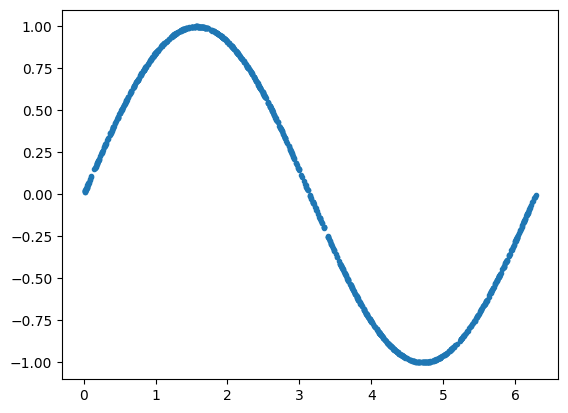

In [28]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

Создадим загрузчик данных с именем train_loader, который будет перетасовывать данные из train_set, возвращая пакеты по 32 образца (batch_size), используемые для обучения нейросети:

In [29]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

Данные готовы, создаем нейронные сети дискриминатора и генератора GAN.

## Реализация дискриминатора
Дискриминатор – это модель с двумерным входом и одномерным выходом. Он получает выборку из реальных данных или от генератора и предоставляет вероятность того, что выборка относится к реальным обучающим данным. Код ниже показывает, как создать класс дискриминатора:

In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

Для построения модели нейронной сети используется стандартный метод классов __init__() . Внутри этого метода мы сначала вызываем super().__init__() для запуска соответствующего метода __init__() наследуемого класса nn.Module. В качестве архитектуры нейросети используется многослойный перцептрон. Его структура послойно задается с помощью nn.Sequential(). Модель имеет следующие характеристики:

двумерный вход;
первый скрытый слой состоит из 256 нейронов и имеет функцию активации ReLU;
в последующих слоях происходит уменьшение числа нейронов до 128 и 64. Вывод имеет сигмоидальную функцию активации, характерную для представления вероятности (Sigmoid);
чтобы избежать переобучения, после первого, второго и третьего скрытых слоев, делается дропаут части нейронов (Dropout).
Для удобства вывода в классе также создан метод forward(). Здесь x соответствует входу модели. В этой реализации выходные данные получаются путем подачи входных данных x в определенную нами модель без предобработки.

После объявления класса дискриминатора создаем его экземпляр:

In [31]:
discriminator = Discriminator()

## Реализация генератора

В генеративно-состязательных сетях генератор – это модель, которая берет в качестве входных данных некоторую выборку из пространства скрытых переменных, напоминающих данные в обучающем наборе. В нашем случае это модель с двумерным вводом, которая будет получать случайные точки (), и двумерный вывод, выдающий точки (), похожие на точки из обучающих данных.

Реализация похожа на то, что мы написали для дискриминатора. Сначала нужно создать класс Generator, наследуемый от nn.Module, затем определить архитектуру нейронной сети, и, наконец, создать экземпляр объекта Generator:

In [32]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

Генератор включает два скрытых слоя с 16 и 32 нейронами с функцией активацией ReLU, а на выходе слой с двумя нейронами с линейной функцией активации. Таким образом, выходные данные будут состоять из двух элементов, имеющих значение в диапазоне от  до , которое будет представлять . То есть исходно мы не накладываем на генератор никакие ограничения – он должен «всему научиться сам».

Теперь, когда мы определили модели для дискриминатора и генератора, мы готовы начать обучение.

## Обучение моделей

Перед обучением моделей необходимо настроить параметры, которые будут использоваться в процессе обучения:

In [33]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

Задаем скорость обучения lr (learning rate), которую мы будем использовать для адаптации весов сети.
Задаем количество эпох num_epochs, которое определяет, сколько повторений процесса обучения будет выполнено с использованием всего датасета.
Переменной loss_function мы назначаем функцию логистической функции потерь (бинарной перекрестной энтропии) BCELoss(). Это та функция потерь, которую мы будем использовать для обучения моделей. Она подходит как для обучения дискриминатора (его задача сводится к бинарной классификации), так и для генератора, так как он подает свой вывод на вход дискриминатора.
Правила обновления весов (обучения модели) в PyTorch реализованы в модуле torch.optim. Мы будем использовать для обучения моделей дискриминатора и генератора алгоритм стохастического градиентного спуска Аdam. Чтобы создать оптимизаторы с помощью torch.optim, запустим следующий код:

In [34]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Рализуем обучающий цикл, в котором образцы обучающей выборки подаются на вход модели, а их веса обновляются, минимизируя функцию потерь:

In [20]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.08785366266965866
Epoch: 0 Loss G.: 2.6136231422424316
Epoch: 10 Loss D.: 0.5747854113578796
Epoch: 10 Loss G.: 1.0368272066116333
Epoch: 20 Loss D.: 0.6020129323005676
Epoch: 20 Loss G.: 0.9719729423522949
Epoch: 30 Loss D.: 0.7193511128425598
Epoch: 30 Loss G.: 0.7410592436790466
Epoch: 40 Loss D.: 0.6888236403465271
Epoch: 40 Loss G.: 0.7364055514335632
Epoch: 50 Loss D.: 0.6827205419540405
Epoch: 50 Loss G.: 0.7755930423736572
Epoch: 60 Loss D.: 0.7062445878982544
Epoch: 60 Loss G.: 0.6951789259910583
Epoch: 70 Loss D.: 0.6769972443580627
Epoch: 70 Loss G.: 0.6815096139907837
Epoch: 80 Loss D.: 0.6979103088378906
Epoch: 80 Loss G.: 0.6745850443840027
Epoch: 90 Loss D.: 0.7083138227462769
Epoch: 90 Loss G.: 0.7205031514167786
Epoch: 100 Loss D.: 0.576349675655365
Epoch: 100 Loss G.: 1.1825348138809204
Epoch: 110 Loss D.: 0.684785008430481
Epoch: 110 Loss G.: 0.6968382000923157
Epoch: 120 Loss D.: 0.6994572281837463
Epoch: 120 Loss G.: 0.7992955446243286
Epoch: 13

На каждой эпохе обучения мы обновляем параметры дискриминатора и генератора. Как это обычно делается для нейронных сетей, учебный процесс состоит из двух вложенных циклов: внешний – для эпох обучения, а внутренний – для пакетов внутри каждой эпохи. Во внутреннем цикле всё начинается с подготовки данных для обучения дискриминатора:

Получаем реальные образцы текущей партии из загрузчика данных и назначаем их переменной real_samples. Обратите внимание, что первое измерение в размерности массива имеет количество элементов, равное batch_size. Это стандартный способ организации данных в PyTorch, где каждая строка тензора представляет один образец из пакета.
Используем torch.ones() для создания меток со значением 1 для реальных образцов и назначаем метки переменной real_samples_labels.
Генерируем образцы, сохраняя случайные данные в latent_space_samples, которые затем передаем в генератор для получения generate_samples. Для меток сгенерированных образцов мы используем нули torch.zeros(), которые сохраняем в generate_samples_labels.
Остается объединить реальные и сгенерированные образцы и метки и сохранить соответственно в all_samples и all_samples_labels.


В следующем блоке мы обучаем дискриминатор:

В PyTorch важно на каждом шаге обучения очищать значения градиентов. Мы делаем это с помощью метода zero_grad().
Вычисляем выходные данные дискриминатора, используя обучающие данные all_samples.
Вычисляем значение функции потерь, используя выходные данные в output_discriminator и метки all_samples_labels.
Вычисляем градиенты для обновления весов с помощью loss_discriminator.backward().
Находим обновленные веса дискриминатора, вызывая optimizer_discriminator.step().
Подготавливаем данные для обучения генератора. Рандомизированные данные хранятся в latent_space_samples, количеством строк равно batch_size. Используем два столбца, чтобы данные соответствовали двумерным данным на входе генератора.


Тренируем генератор:

Очищаем градиенты с помощью метода zero_grad().
Передаем генератору latent_space_samples и сохраняем его выходные данные в generate_samples.
Передаем выходные данные генератора в дискриминатор и сохраняем его выходные данные в output_discriminator_generated, который будет использоваться в качестве выходных данных всей модели.
Вычисляем функцию потерь, используя выходные данные системы классификации, сохраненные в output_discriminator_generated и метки real_samples_labels, равные 1.
Рассчитываем градиенты и обновляем веса генератора. Помните, что когда мы обучаем генератор, мы сохраняем веса дискриминатора в замороженном состоянии.
Наконец, в последних строчках цикла происходит вывод значения функций потерь дискриминатора и генератора в конце каждой десятой эпохи.



##Проверка образцов, сгенерированных GAN

Генеративно-состязательные сети предназначены для генерации данных, поэтому после того как процесс обучения завершен, мы можем вызвать генератор для получения новых данных:

In [23]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

Построим сгенерированные данные и проверим, насколько они похожи на обучающие данные. Перед построением графика для сгенерированных образцов необходимо применить .detach(), чтобы получить необходимые данные из вычислительного графа PyTorch:

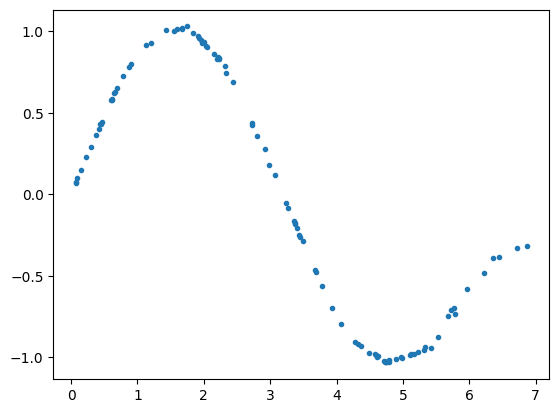

In [24]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

Распределение сгенерированных данных очень напоминает реальные данные – исходный синус.

## Генератор рукописных цифр с GAN
Когда мы реализовали первую модель генеративно-состязательной сети, мы можем перейти к практическому примеру с генерацией изображений.
В
оспользуемся GAN для генерации изображений рукописных цифр. Для этого мы обучим модели, используя набор данных MNIST), состоящий из рукописных цифр. Этот стандартный набор данных включен в пакет torchvision.

In [35]:
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(111)

In [36]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Подготовка датасета MNIST

Набор данных MNIST состоит из изображений написанных от руки цифр от 0 до 9. Изображения выполнены в градациях серого и имеют размер 28 × 28 пикселей. Чтобы использовать их с PyTorch, понадобится выполнить преобразования. Для этого определим функцию transform, используемую при загрузке данных:

In [37]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Функция состоит из двух частей:

transforms.ToTensor() преобразует данные в тензор PyTorch.
transforms.Normalize() преобразует диапазон тензорных коэффициентов.
Исходные коэффициенты, заданные функцией transforms.ToTensor(), находятся в диапазоне от 0 до 1. Поскольку изображения имеют черный фон, большинство коэффициентов равны 0.



Функция transforms.Normalize() изменяет диапазон коэффициентов на , вычитая 0.5 из исходных коэффициентов и деля результат на 0.5. Преобразование сокращает количество элементов входных выборок, равных 0. Это помогает в обучении моделей.

Теперь можно загрузить обучающие данные, вызвав torchvision.datasets.MNIST:

In [38]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 41443795.64it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 1081955.11it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 9589688.28it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13520602.39it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [39]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

Для избирательного построения данных воспользуемся matplotlib. В качестве палитры хорошо подходит cmap = gray_r. Цифры будут изображаться черным цветом на белом фоне:

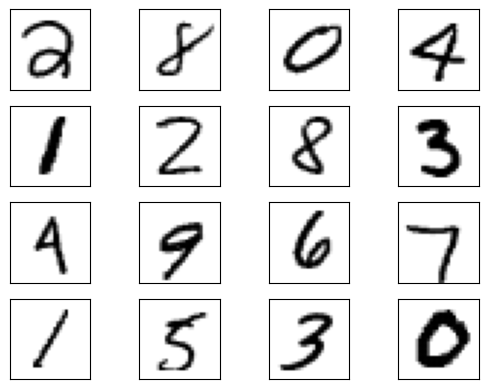

In [41]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

##Реализация дискриминатора и генератора

После подготовки обучающих данных, можно реализовать модели дискриминатора и генератора.
В рассматриваемом случае дискриминатором является нейронная сеть многослойного перцептрона, которая принимает изображение размером 28 × 28 пикселей и находит вероятность того, что изображение принадлежит реальным обучающим данным.

Модель можно определить с помощью следующего кода:

In [42]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

Чтобы ввести коэффициенты изображения в нейронную сеть перцептрона, необходимо их векторизовать так, чтобы нейронная сеть получала вектор, состоящий из 784 коэффициентов (28 × 28 = 784).

Векторизация происходит в первой строке метода forward() – вызов x.view() преобразует форму входного тензора. Исходная форма тензора  – 32 × 1 × 28 × 28, где 32 – размер партии. После преобразования форма  становится равной 32 × 784, причем каждая строка представляет коэффициенты изображения обучающего набора.

Чтобы запустить модель дискриминатора с использованием графического процессора, нужно создать его экземпляр и связать с объектом устройства с помощью метода .to():

In [43]:
discriminator = Discriminator().to(device=device)

Генератор будет создавать более сложные данные, чем в предыдущем примере. Поэтому необходимо увеличить размеры входных данных, используемых для инициализации. Здесь мы используем 100-мерный вход и выход с 784 коэффициентами. Результат организуется в виде тензора 28 × 28, представляющего изображение.

In [44]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

Выходные коэффициенты должны находиться в интервале от -1 до 1. Поэтому на выходе генератора мы используем гиперболическую функцию активации Tanh(). В последней строке мы создаем экземпляр генератора и связываем его с объектом устройства.

##Обучение моделей

Для обучения моделей нужно определить параметры обучения и оптимизаторы:

In [45]:
lr = 0.0001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Чтобы получить лучший результат, мы уменьшаем скорость обучения по сравнению с предыдущим примером. Чтобы сократить время обучения, устанавливаем количество эпох равным 50.

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Показываем loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6093966364860535
Epoch: 0 Loss G.: 0.44796624779701233
Epoch: 1 Loss D.: 0.13803152740001678
Epoch: 1 Loss G.: 3.8762338161468506
Epoch: 2 Loss D.: 0.029784033074975014
Epoch: 2 Loss G.: 3.668170690536499
Epoch: 3 Loss D.: 0.013347405940294266
Epoch: 3 Loss G.: 8.248342514038086
Epoch: 4 Loss D.: 0.009162716567516327
Epoch: 4 Loss G.: 4.895168781280518
Epoch: 5 Loss D.: 0.11050840467214584
Epoch: 5 Loss G.: 6.675764083862305
Epoch: 6 Loss D.: 0.019904471933841705
Epoch: 6 Loss G.: 5.134044647216797
Epoch: 7 Loss D.: 0.0002651131362654269
Epoch: 7 Loss G.: 7.995906829833984
Epoch: 8 Loss D.: 0.0024874783121049404
Epoch: 8 Loss G.: 6.514123916625977
Epoch: 9 Loss D.: 1.1499541869852692e-05
Epoch: 9 Loss G.: 11.648590087890625
Epoch: 10 Loss D.: 1.8311386156710796e-05
Epoch: 10 Loss G.: 12.048354148864746
Epoch: 11 Loss D.: 0.00010330290388083085
Epoch: 11 Loss G.: 8.835368156433105
Epoch: 12 Loss D.: 0.0002411371242487803
Epoch: 12 Loss G.: 8.92755126953125
Epoch: 13 

##Проверка сгенерированных GAN образцов


Сгенерируем несколько образцов «рукописных цифр». Для этого передадим генератору набор случайных чисел.

Чтобы построить сгенерированные выборки, нужно переместить данные обратно в центральный процессор, если их обработка происходила на графическом процессоре. Для этого достаточно вызвать метод cpu(). Как и раньше, перед построением данных необходимо вызвать .detach():

In [ ]:
atent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

В начале процесса обучения сгенерированные изображения абсолютно случайны. По мере обучения генератор изучает распределение реальных данных, и примерно через двадцать эпох некоторые сгенерированные изображения цифр уже напоминают реальные данные.

## Вывод:
Выбран пример GAN с генерацией рукописных цифр.
На данном примере взятом видно как обучается и работает, генеративная состязательная сеть (GAN).
Удалось улучшить результат генерации рукописных цифр, увеличив количество эпох до 100, при обучении НС. Модель нейронной сети построена на PyTorch.